## Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import StackingClassifier, RandomForestClassifier,VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import  precision_recall_curve,PrecisionRecallDisplay

### Dataset Overview

In [6]:
train_data = pd.read_csv("/Users/macbookpro/Downloads/ml4sbu/train.csv")
test_data = pd.read_csv("/Users/macbookpro/Downloads/ml4sbu/test.csv")
sample_data=pd.read_csv("/Users/macbookpro/Downloads/ml4sbu/sample_submission.csv")

In [7]:
train_data.info()
train_data.shape
train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             1341 non-null   int64 
 1   age_years              1341 non-null   int64 
 2   travel_freq            1341 non-null   object
 3   daily_salary           1341 non-null   int64 
 4   work_division          1341 non-null   object
 5   commute_distance       1341 non-null   int64 
 6   education_level        1341 non-null   int64 
 7   degree_field           1341 non-null   object
 8   headcount              1341 non-null   int64 
 9   env_satisfaction       1341 non-null   int64 
 10  sex                    1341 non-null   object
 11  hourly_wage            1341 non-null   int64 
 12  job_engagement         1341 non-null   int64 
 13  position_level         1341 non-null   int64 
 14  job_title              1341 non-null   object
 15  job_satisfaction     

,Unnamed: 0,age_years,travel_freq,daily_salary,work_division,commute_distance,education_level,degree_field,headcount,env_satisfaction,...,std_work_hours,stock_level,career_years,trainings_last_year,work_life_score,tenure_years,years_current_role,years_post_promotion,years_with_manager,left_company
0,0,27,frequent_travel,1302,rnd,2,2,life_sci,1,2,...,80,1,8,5,3,8,7,0,1,0
1,1,32,rare_travel,1476,rnd,28,2,life_sci,1,1,...,80,0,8,3,3,4,1,1,3,0
2,2,44,rare_travel,1275,rnd,9,2,medical,1,3,...,80,1,10,2,3,9,8,1,7,0
3,3,46,rare_travel,1320,sales,24,4,marketing,1,4,...,80,1,28,3,3,22,11,15,8,0
4,4,42,rare_travel,442,rnd,1,4,life_sci,1,1,...,80,1,10,3,1,8,7,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,1336,35,rare_travel,584,rnd,11,2,life_sci,1,4,...,80,0,10,2,3,10,0,3,9,0
1337,1337,31,rare_travel,1082,sales,6,4,other,1,2,...,80,1,4,3,2,3,2,1,2,0
1338,1338,36,no_travel,855,rnd,1,4,life_sci,1,1,...,80,2,10,3,2,10,7,7,7,0
1339,1339,27,frequent_travel,1225,sales,5,2,life_sci,1,3,...,80,1,3,2,3,3,2,0,2,0


In [8]:
duplicates = train_data.columns[train_data.T.duplicated()]
print("Duplicate columns:", list(duplicates))

train_data.isnull().sum()

Duplicate columns: []


Unnamed: 0               0
age_years                0
travel_freq              0
daily_salary             0
work_division            0
commute_distance         0
education_level          0
degree_field             0
headcount                0
env_satisfaction         0
sex                      0
hourly_wage              0
job_engagement           0
position_level           0
job_title                0
job_satisfaction         0
marital_state            0
monthly_earnings         0
monthly_salary           0
companies_count          0
is_adult                 0
overtime_status          0
salary_increase_pct      0
performance_score        0
relation_satisfaction    0
std_work_hours           0
stock_level              0
career_years             0
trainings_last_year      0
work_life_score          0
tenure_years             0
years_current_role       0
years_post_promotion     0
years_with_manager       0
left_company             0
dtype: int64

In [9]:
# Detect Outliers (remove)

def find_outliers_IQR(full_data):
    outliers = pd.DataFrame()
    for col in full_data.select_dtypes(include='number').columns:
        q1 = full_data[col].quantile(0.25)
        q3 = full_data[col].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR
        outlier_mask = (full_data[col] < lower_bound) | (full_data[col] > upper_bound)
        outliers[col] = full_data[col][outlier_mask]
    return outliers

print(find_outliers_IQR(train_data))

def drop_outliers_IQR(full_data):
    for col in full_data.select_dtypes(include='number').columns:
        q1 = full_data[col].quantile(0.25)
        q3 = full_data[col].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR
        full_data = full_data[(full_data[col] >= lower_bound) & (full_data[col] <= upper_bound)]
    return full_data
def treat_outliers_IQR(full_data):
    treated_data = full_data.copy()
    for col in treated_data.select_dtypes(include='number').columns:
        q1 = treated_data[col].quantile(0.25)
        q3 = treated_data[col].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5 * IQR
        upper_bound = q3 + 1.5 * IQR

        treated_data[col] = treated_data[col].apply(
            lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
        )
    return treated_data

full_data = treat_outliers_IQR(train_data)
print(full_data)


      Unnamed: 0  age_years  daily_salary  commute_distance  education_level  \
44           NaN         59           NaN               NaN              NaN   
89           NaN         59           NaN               NaN              NaN   
111          NaN         58           NaN               NaN              NaN   
313          NaN         58           NaN               NaN              NaN   
318          NaN         59           NaN               NaN              NaN   
345          NaN         60           NaN               NaN              NaN   
583          NaN         59           NaN               NaN              NaN   
629          NaN         60           NaN               NaN              NaN   
681          NaN         59           NaN               NaN              NaN   
702          NaN         58           NaN               NaN              NaN   
705          NaN         58           NaN               NaN              NaN   
717          NaN         59           Na

In [10]:
#Categorial Variables to Numerical (Train Data)
train_datas = train_data.select_dtypes(include=['object']).columns
for col in train_datas:
    train_data[col] = pd.factorize(train_data[col])[0]

print(train_data)

#Categorial Variables to Numerical (Test DATA)
test_datas = test_data.select_dtypes(include=['object']).columns
for col in test_datas:
    test_data[col] = pd.factorize(test_data[col])[0]

      Unnamed: 0  age_years  travel_freq  daily_salary  work_division  \
0              0         27            0          1302              0   
1              1         32            1          1476              0   
2              2         44            1          1275              0   
3              3         46            1          1320              1   
4              4         42            1           442              0   
...          ...        ...          ...           ...            ...   
1336        1336         35            1           584              0   
1337        1337         31            1          1082              1   
1338        1338         36            2           855              0   
1339        1339         27            0          1225              1   
1340        1340         48            2          1356              1   

      commute_distance  education_level  degree_field  headcount  \
0                    2                2             0  

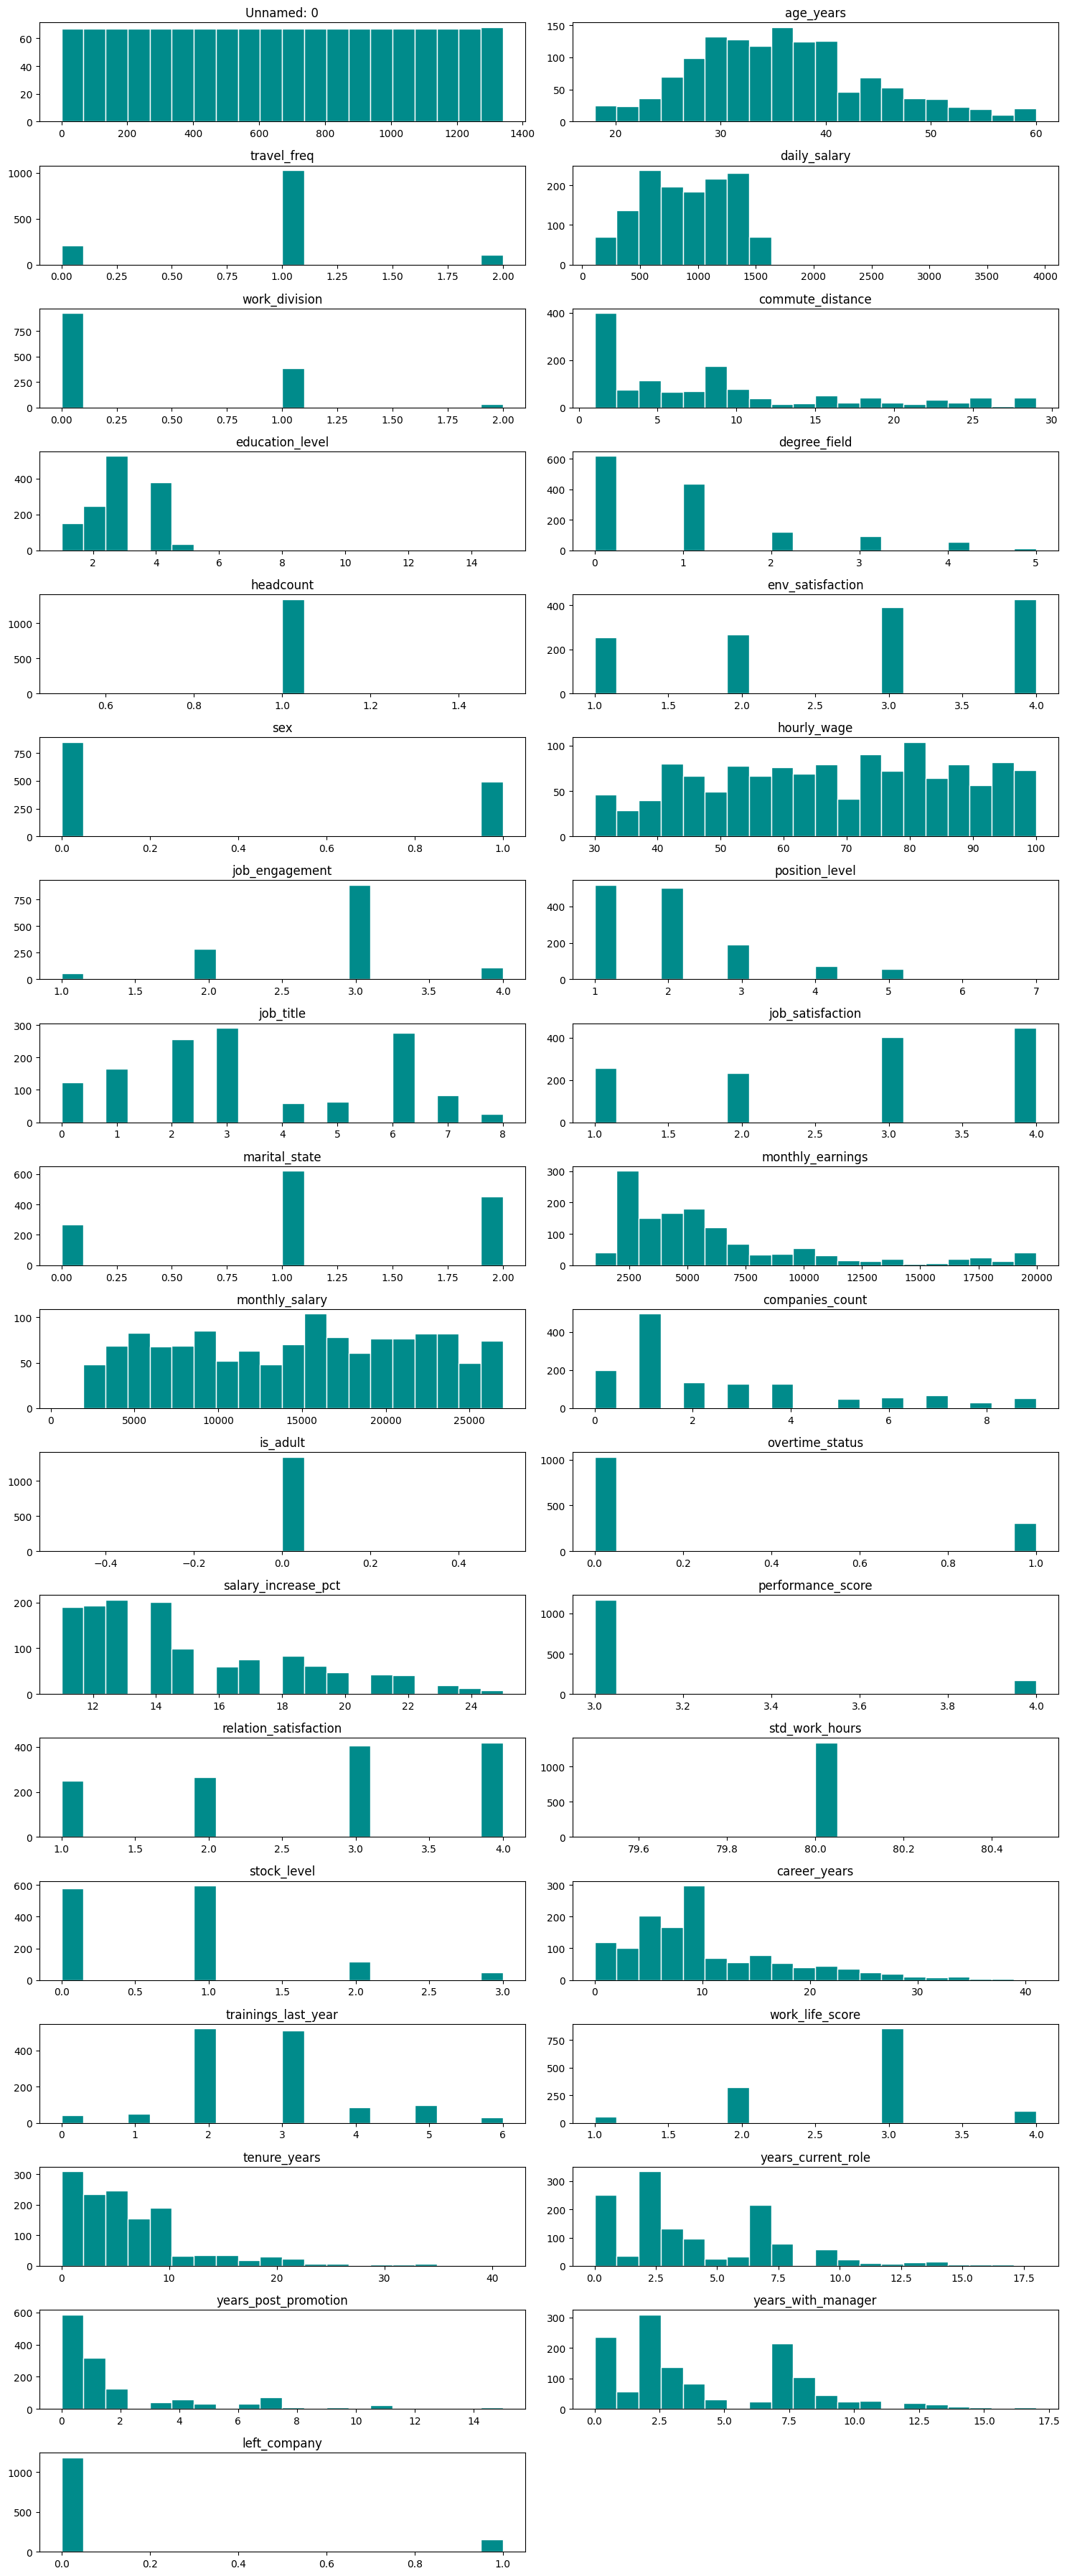

In [11]:
# EDA
numeric_columns = train_data.select_dtypes(include=['int64', 'float64'])
num_cols = len(numeric_columns.columns)
num_rows = int(np.ceil(num_cols / 2))
fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 2))
axs = axs.flatten()
for i, col in enumerate(numeric_columns.columns):
    axs[i].hist(numeric_columns[col], bins=20, edgecolor="white" , color='darkcyan')
    axs[i].set_title(col)

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

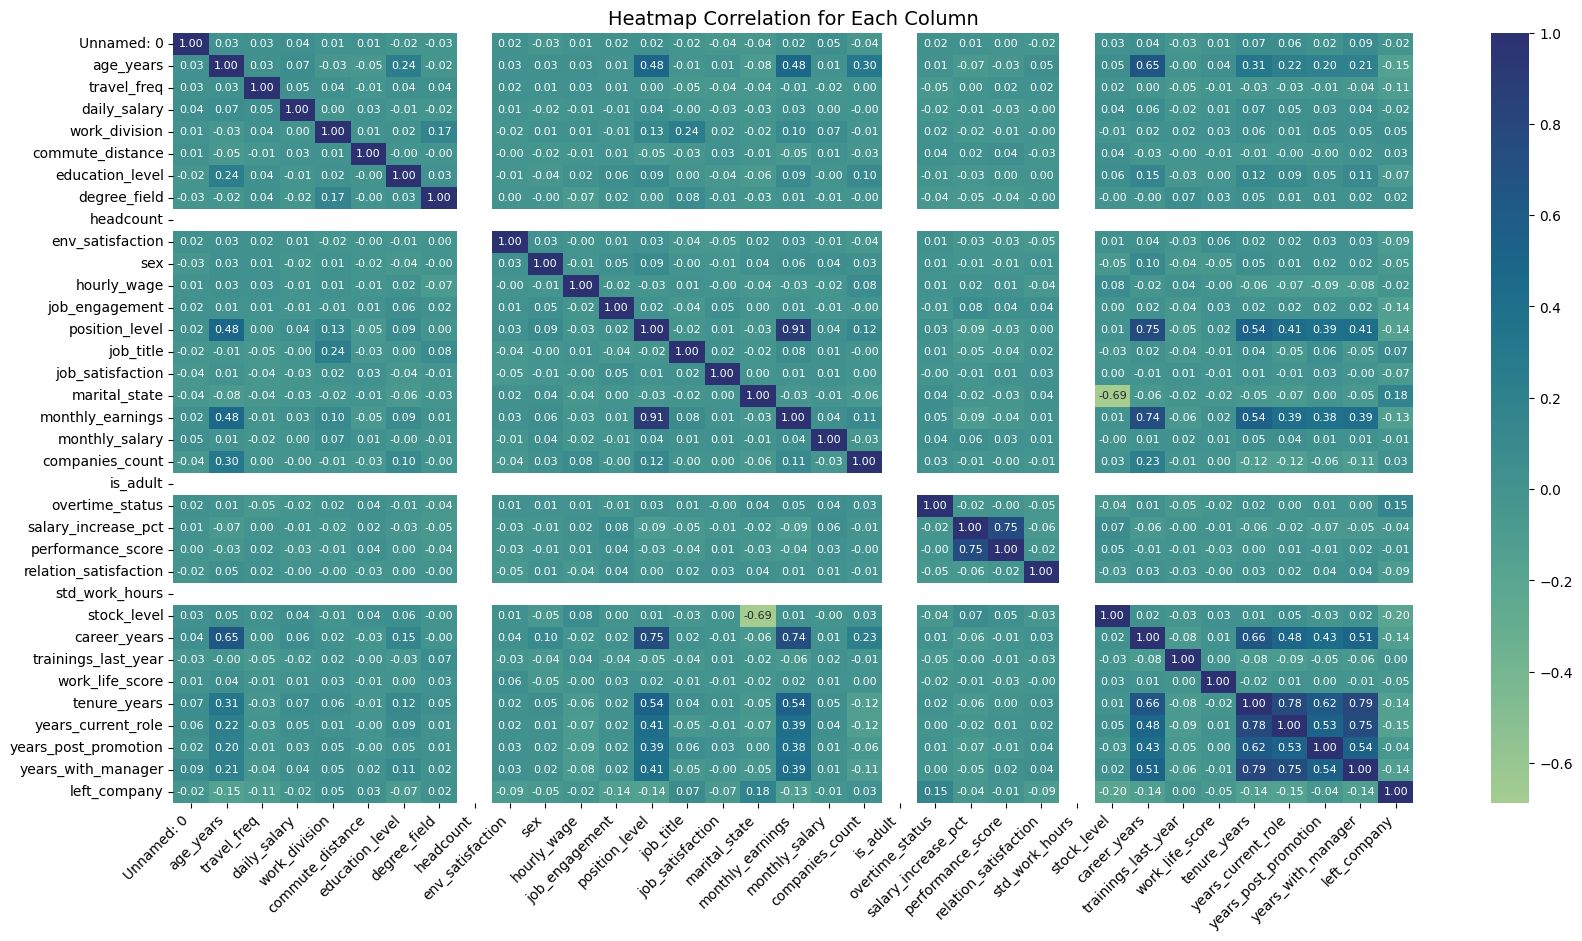

In [12]:
# [Heatmap] --> Correlation For Each Column
corr_matrix = train_data.select_dtypes(include=['number']).corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='crest', fmt=".2f", annot_kws={"size": 8})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title("Heatmap Correlation for Each Column", fontsize=14)
plt.show()

### BaseLine Model

In [13]:
# Features
feature_cols = [col for col in train_data.columns if col not in ['left_company', 'Unnamed: 0']]
X = train_data[feature_cols]
y = train_data['left_company']
X_sample = test_data[feature_cols]
data1 = train_data.copy(deep=True)
data_cleaner = [data1, test_data]
data_cleaner

[      Unnamed: 0  age_years  travel_freq  daily_salary  work_division  \
 0              0         27            0          1302              0   
 1              1         32            1          1476              0   
 2              2         44            1          1275              0   
 3              3         46            1          1320              1   
 4              4         42            1           442              0   
 ...          ...        ...          ...           ...            ...   
 1336        1336         35            1           584              0   
 1337        1337         31            1          1082              1   
 1338        1338         36            2           855              0   
 1339        1339         27            0          1225              1   
 1340        1340         48            2          1356              1   
 
       commute_distance  education_level  degree_field  headcount  \
 0                    2                2 

In [14]:
feature_cols = [col for col in train_data.columns if col not in ['left_company', 'Unnamed: 0', 'ID']]

corr = train_data[feature_cols].corr()

top_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .abs()
    .sort_values(ascending=False)
    .head(10)
)

print(top_pairs)


numerics = train_data.select_dtypes(include='number').drop(columns=['left_company']).columns

scaler = StandardScaler()
train_data[numerics] = scaler.fit_transform(train_data[numerics])
test_data[numerics] = scaler.transform(test_data[numerics])


position_level       monthly_earnings      0.906910
tenure_years         years_with_manager    0.792115
                     years_current_role    0.775484
years_current_role   years_with_manager    0.754404
position_level       career_years          0.753900
salary_increase_pct  performance_score     0.746755
monthly_earnings     career_years          0.735746
marital_state        stock_level           0.686920
career_years         tenure_years          0.660944
age_years            career_years          0.651054
dtype: float64


In [15]:
# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_sample_scaled = scaler.transform(X_sample)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_sample shape: {X_sample.shape}")

X_train shape: (1072, 33), X_val shape: (269, 33), X_sample shape: (336, 33)


In [16]:
# Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    # GLM (Generalized Linear Models)
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),  # no probability=True here
    
    # Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # XGBoost
    XGBClassifier(),
]


In [17]:
MLA = [
    LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    SVC(probability=True, class_weight='balanced', random_state=42)
]

cv_split = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

MLA_columns = [
    'MLA Name',
    'MLA Parameters',
    'MLA Train Accuracy Mean',
    'MLA Test Accuracy Mean',
    'MLA Test Accuracy 3*STD',
    'MLA Time'
]

MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = pd.DataFrame(data1['left_company'].copy())

for row_index, alg in enumerate(MLA):
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    try:
        cv_results = model_selection.cross_validate(
            alg,
            data1[feature_cols],   
            data1['left_company'],        
            cv=cv_split,
            return_train_score=True,
            n_jobs=-1,
            error_score='raise'  
        )
        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3
        alg.fit(data1[feature_cols], data1['left_company'])
        MLA_predict[MLA_name] = alg.predict(data1[feature_cols])
    except Exception as e:
        print(f"Model {MLA_name} failed: {e}")
        MLA_compare.loc[row_index, ['MLA Time', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD']] = [None]*4
        MLA_predict[MLA_name] = None

MLA_compare.sort_values(by='MLA Test Accuracy Mean', ascending=False, inplace=True)
print(MLA_compare)


NameError: name 'model_selection' is not defined

Text(0, 0.5, 'Algorithm')

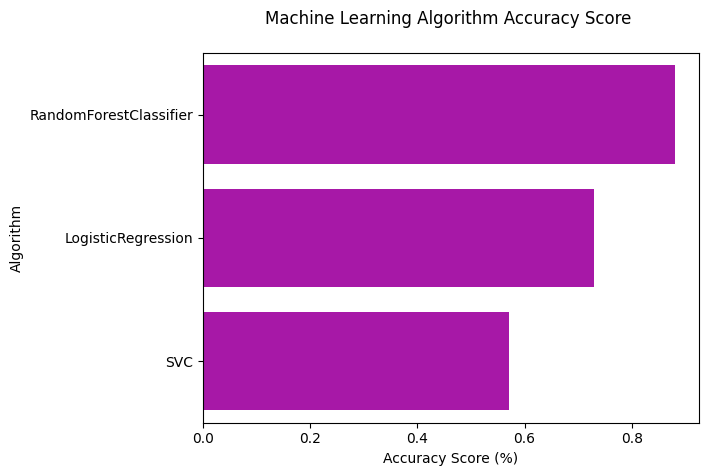

In [ ]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [ ]:
# Logistic Regression (Without Class Weights)
no_weights = LogisticRegression(max_iter=1000, random_state=42)
no_weights.fit(X_train, y_train)

y_pred_no_weights = no_weights.predict(X_val)

print(confusion_matrix(y_val, y_pred_no_weights))
print(classification_report(y_val, y_pred_no_weights))


[[236   2]
 [ 29   2]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       238
           1       0.50      0.06      0.11        31

    accuracy                           0.88       269
   macro avg       0.70      0.53      0.53       269
weighted avg       0.85      0.88      0.84       269



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


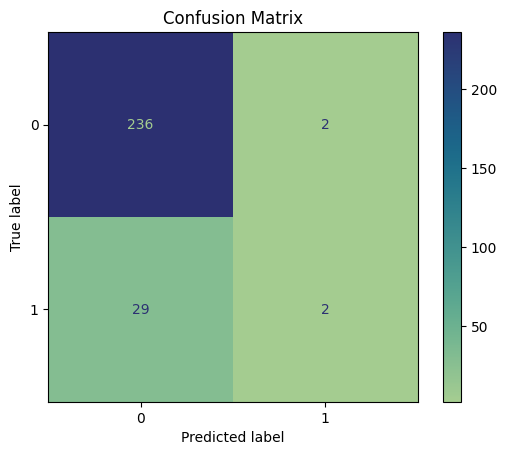

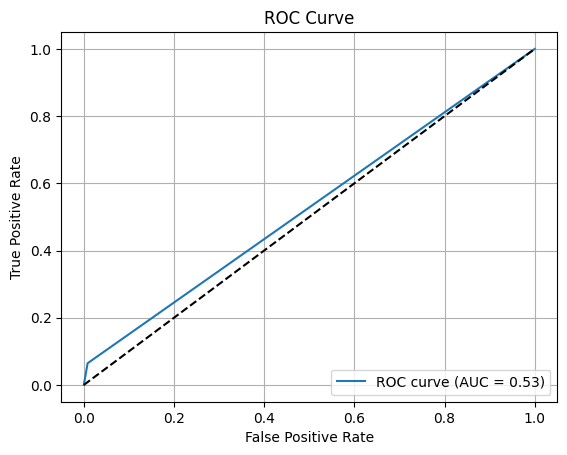

In [ ]:
cm_display = ConfusionMatrixDisplay.from_estimator(no_weights, X_val, y_val, cmap='crest')
plt.title('Confusion Matrix')
plt.show()

part1, part2, thresholds = roc_curve(y_val, y_pred_no_weights)
auc_score = roc_auc_score(y_val, y_pred_no_weights)

plt.figure()
plt.plot(part1, part2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
#  Logistic Regression (With Class Weights)
with_weights = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
with_weights.fit(X_train, y_train)

y_pred_weights = with_weights.predict(X_val)

print(confusion_matrix(y_val, y_pred_weights))
print(classification_report(y_val, y_pred_weights))


[[177  61]
 [  7  24]]
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       238
           1       0.28      0.77      0.41        31

    accuracy                           0.75       269
   macro avg       0.62      0.76      0.63       269
weighted avg       0.88      0.75      0.79       269



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


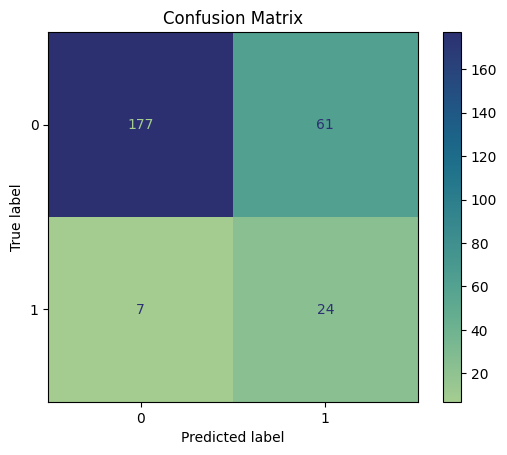

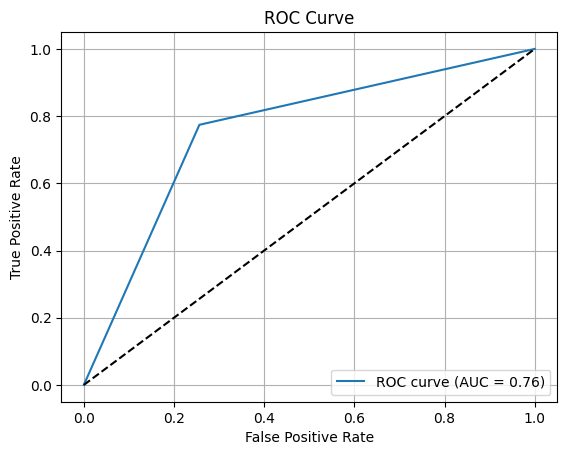

In [ ]:
cm_display = ConfusionMatrixDisplay.from_estimator(with_weights, X_val, y_val, cmap='crest')
plt.title('Confusion Matrix')
plt.show()

part1, part2, thresholds = roc_curve(y_val, y_pred_weights)
auc_score = roc_auc_score(y_val, y_pred_weights)

plt.figure()
plt.plot(part1, part2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Advanced Models

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

knn_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_val)
y_proba_knn = knn_pipeline.predict_proba(X_val)[:, 1]

nb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('nb', GaussianNB())
])
nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_val)
y_proba_nb = nb_pipeline.predict_proba(X_val)[:, 1]

In [ ]:
from sklearn.model_selection import GridSearchCV
pipeline_rbf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
])

param_grid_rbf = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.01, 0.1, 1]
}

grid_rbf = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=5, scoring='f1', n_jobs=-1)
grid_rbf.fit(X_train, y_train)

best_rbf = grid_rbf.best_estimator_
y_pred_rbf = best_rbf.predict(X_val)
y_proba_rbf = best_rbf.predict_proba(X_val)[:, 1]


In [ ]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n=== {name} ===")
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_proba))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    part1, part2, _ = roc_curve(y_true, y_proba)
    plt.plot(part1, part2, label=name)



=== SVM RBF ===
F1 Score: 0.28776978417266186
ROC AUC Score: 0.5969775006776904

=== KNN ===
F1 Score: 0.1889763779527559
ROC AUC Score: 0.5040661425860666

=== Naive Bayes ===
F1 Score: 0.34234234234234234
ROC AUC Score: 0.701409596096503


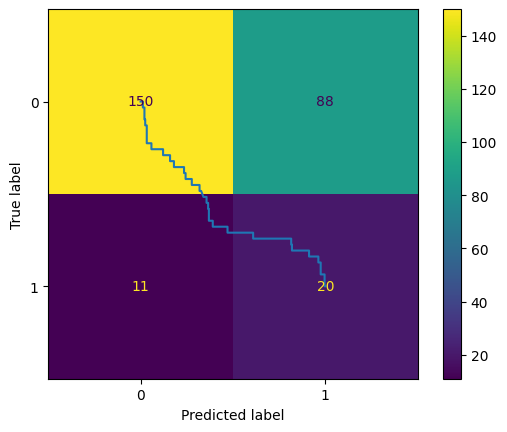

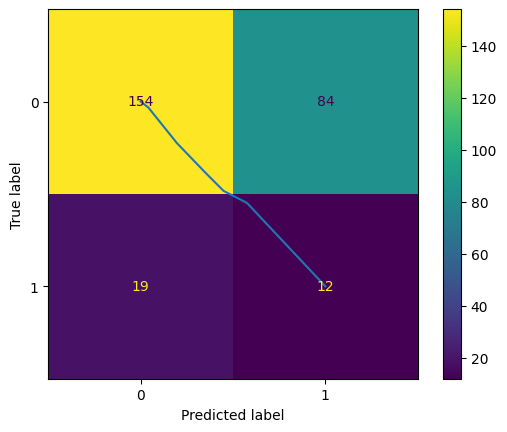

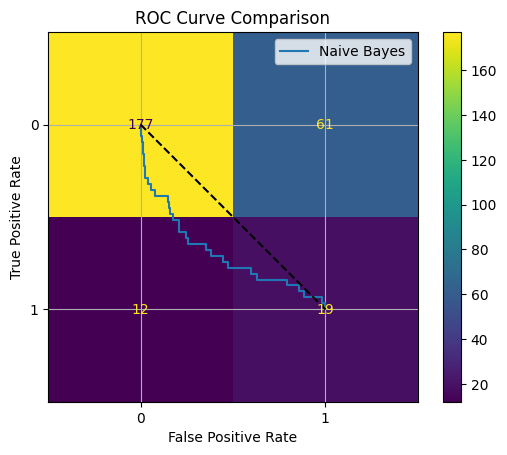

In [ ]:
# RBF SVM Evaluation
evaluate_model("SVM RBF", y_val, y_pred_rbf, y_proba_rbf)
# KNN
evaluate_model("KNN", y_val, y_pred_knn, y_proba_knn)
# Naive Bayes
evaluate_model("Naive Bayes", y_val, y_pred_nb, y_proba_nb)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

### BONUS

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import numpy as np

class SimpleRandomForest:
    def __init__(self, n_estimators=10, max_depth=None, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = resample(X, y)
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict_proba(self, X):
        # Average probabilities
        proba = np.mean([tree.predict_proba(X) for tree in self.trees], axis=0)
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)



=== Simple RF (from scratch) ===
F1 Score: 0.06060606060606061
ROC AUC Score: 0.8048251558687991

=== Library RF ===
F1 Score: 0.11764705882352941
ROC AUC Score: 0.8152615885063702

=== KNN ===
F1 Score: 0.0
ROC AUC Score: 0.5372729737056112

=== Naive Bayes ===
F1 Score: 0.3953488372093023
ROC AUC Score: 0.7191650853889943


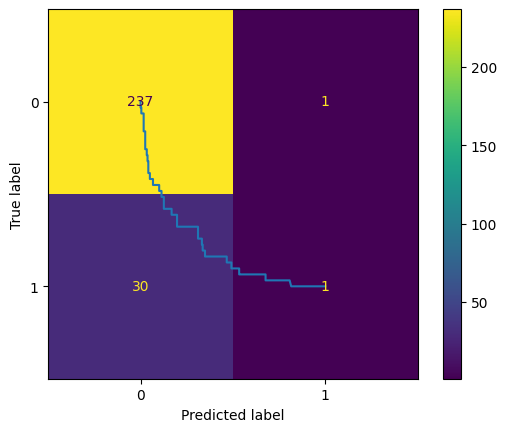

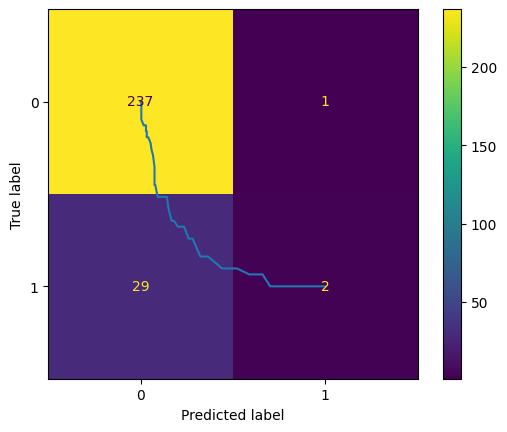

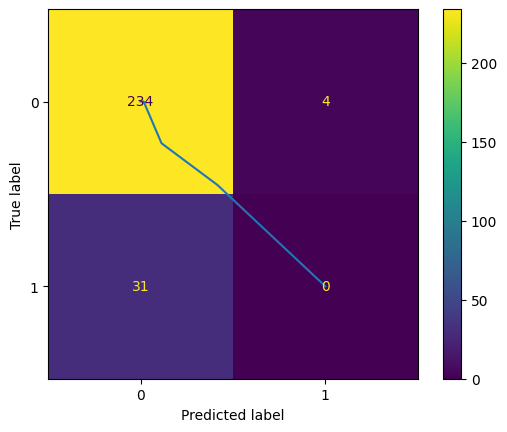

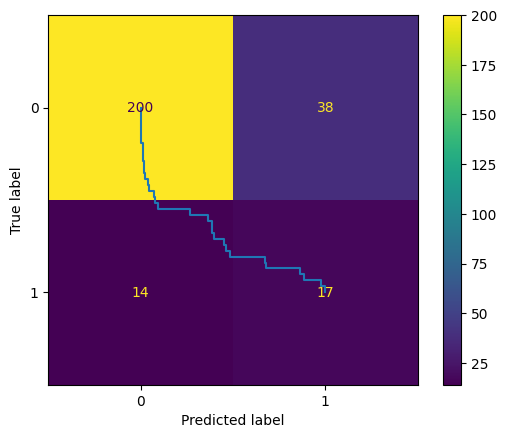

In [ ]:
# From-scratch Random Forest
my_rf = SimpleRandomForest(n_estimators=10, max_depth=5)
my_rf.fit(X_train, y_train)
y_pred_my_rf = my_rf.predict(X_val)
y_proba_my_rf = my_rf.predict_proba(X_val)[:, 1]
evaluate_model("Simple RF (from scratch)", y_val, y_pred_my_rf, y_proba_my_rf)

# Library Random Forest
from sklearn.ensemble import RandomForestClassifier
lib_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
lib_rf.fit(X_train, y_train)
y_pred_lib_rf = lib_rf.predict(X_val)
y_proba_lib_rf = lib_rf.predict_proba(X_val)[:, 1]
evaluate_model("Library RF", y_val, y_pred_lib_rf, y_proba_lib_rf)

# k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)
y_proba_knn = knn.predict_proba(X_val)[:, 1]
evaluate_model("KNN", y_val, y_pred_knn, y_proba_knn)

# Naïve Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_val)
y_proba_nb = nb.predict_proba(X_val)[:, 1]
evaluate_model("Naive Bayes", y_val, y_pred_nb, y_proba_nb)



=== Simple RF (from scratch) ===
F1 Score: 0.06060606060606061
ROC AUC Score: 0.8048251558687991

=== Library RF ===
F1 Score: 0.11764705882352941
ROC AUC Score: 0.8152615885063702

=== KNN ===
F1 Score: 0.0
ROC AUC Score: 0.5372729737056112

=== Naive Bayes ===
F1 Score: 0.3953488372093023
ROC AUC Score: 0.7191650853889943


<Figure size 1000x800 with 0 Axes>

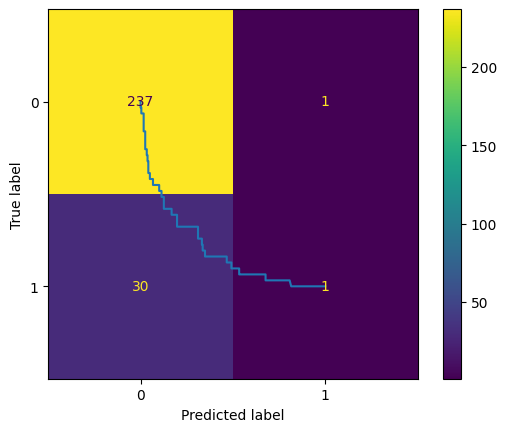

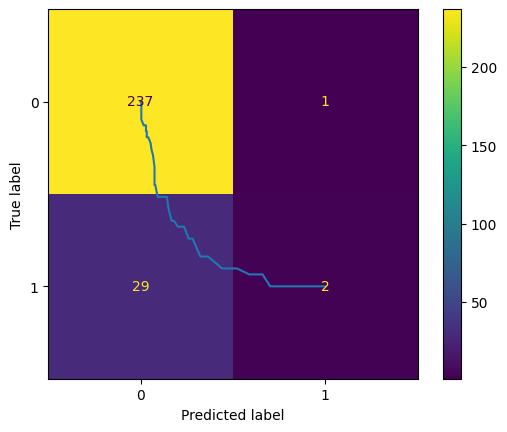

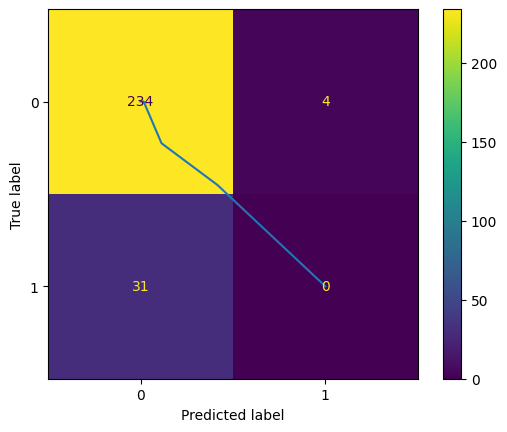

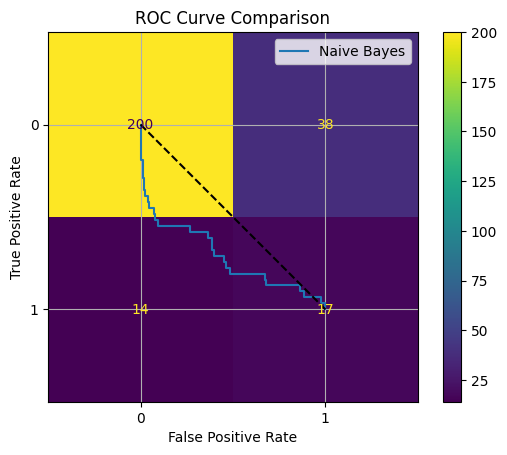

In [ ]:
plt.figure(figsize=(10, 8))
evaluate_model("Simple RF (from scratch)", y_val, y_pred_my_rf, y_proba_my_rf)
evaluate_model("Library RF", y_val, y_pred_lib_rf, y_proba_lib_rf)
evaluate_model("KNN", y_val, y_pred_knn, y_proba_knn)
evaluate_model("Naive Bayes", y_val, y_pred_nb, y_proba_nb)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


### Handling Imbalanced Data


=== Logistic Regression (class_weight) ===
F1 Score: 0.42857142857142855
ROC AUC Score: 0.8125508267823258

=== SVM RBF (class_weight) ===
F1 Score: 0.25
ROC AUC Score: 0.6223908918406071

=== LogReg + Threshold = 0.3 ===
F1 Score: 0.3312883435582822
ROC AUC Score: 0.8125508267823258


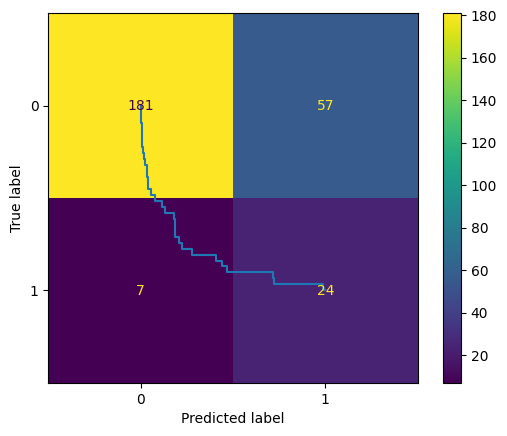

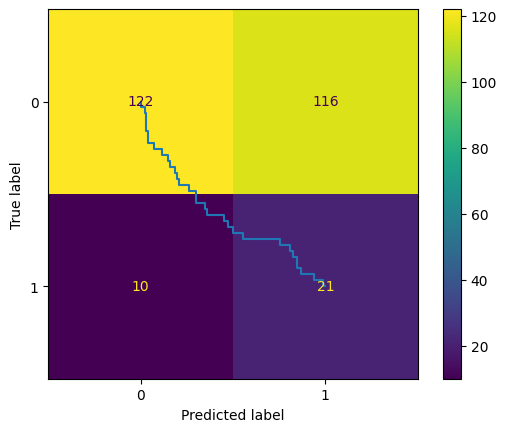

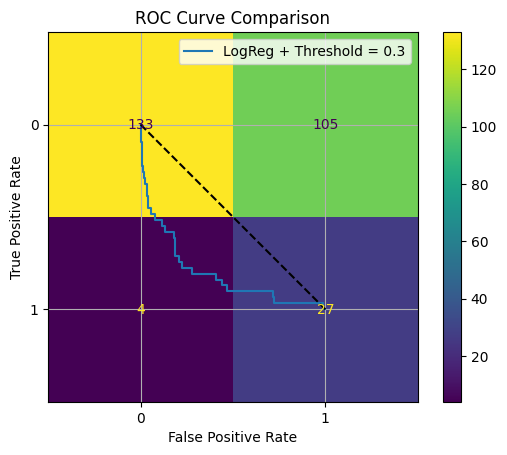

In [ ]:
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
lr_balanced.fit(X_train, y_train)
y_pred_lr = lr_balanced.predict(X_val)
y_proba_lr = lr_balanced.predict_proba(X_val)[:, 1]
evaluate_model("Logistic Regression (class_weight)", y_val, y_pred_lr, y_proba_lr)

svm_balanced = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_balanced.fit(X_train, y_train)
y_pred_svm = svm_balanced.predict(X_val)
y_proba_svm = svm_balanced.predict_proba(X_val)[:, 1]
evaluate_model("SVM RBF (class_weight)", y_val, y_pred_svm, y_proba_svm)

proba_lr = lr_balanced.predict_proba(X_val)[:, 1]

custom_threshold = 0.3
y_pred_thresh = (proba_lr >= custom_threshold).astype(int)

evaluate_model("LogReg + Threshold = 0.3", y_val, y_pred_thresh, proba_lr)


plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()



### Model Stacking (Optional)


=== Stacked Model ===
F1 Score: 0.11764705882352941
ROC AUC Score: 0.8277310924369747


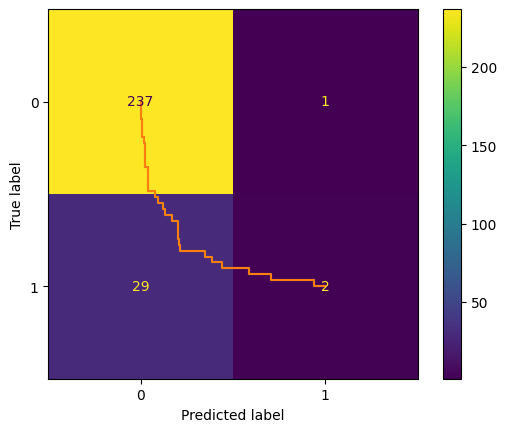

In [ ]:
base_models = [
    ('lr', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42))
]

meta_model = LogisticRegression()

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=False,  
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_val)
y_proba_stack = stacking_clf.predict_proba(X_val)[:, 1]

evaluate_model("Stacked Model", y_val, y_pred_stack, y_proba_stack)
part1_stack, part2_stack, _ = roc_curve(y_val, y_proba_stack)
plt.plot(part1_stack, part2_stack, label='Stacked Model')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:27:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:28:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:28:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:28:02] WARN

Best threshold by F1 score: 0.22
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       238
           1       0.59      0.55      0.57        31

    accuracy                           0.90       269
   macro avg       0.76      0.75      0.76       269
weighted avg       0.90      0.90      0.90       269



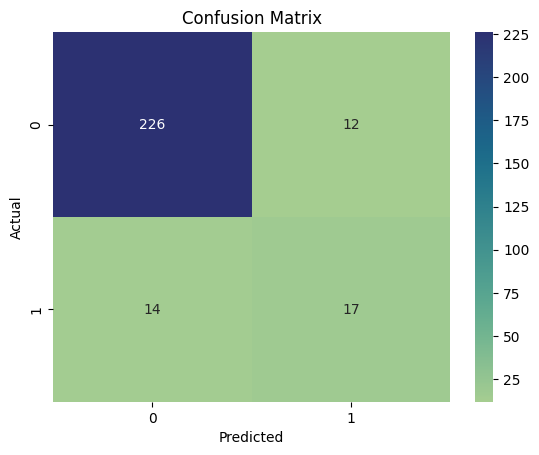

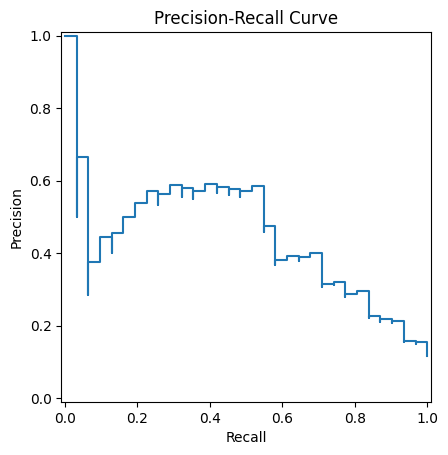

In [18]:
LR = LogisticRegression(class_weight='balanced', random_state=42)
RF = RandomForestClassifier(class_weight='balanced', random_state=42)
XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

SVC_model = SVC(probability=True, random_state=42)  

vote = VotingClassifier(
    estimators=[('lr', LR), ('rf', RF), ('svc', SVC_model), ('xgb', XGB)],
    voting='soft',
    weights=[1, 2, 1, 2]
)
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=30)
X_train_RFE = rfe_selector.fit_transform(X_train_scaled, y_train)
vote.fit(X_train_RFE, y_train)

calibrated_vote = CalibratedClassifierCV(vote, cv=5)
calibrated_vote.fit(X_train_RFE, y_train)
X_val_RFE = rfe_selector.transform(X_val_scaled)
val_probs = calibrated_vote.predict_proba(X_val_RFE)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold by F1 score: {best_threshold:.2f}")

# Apply best threshold
val_preds = (val_probs >= best_threshold).astype(int)

print(classification_report(y_val, val_preds))


cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

pr_display = PrecisionRecallDisplay(precision=precisions, recall=recalls)
pr_display.plot()
plt.title('Precision-Recall Curve')
plt.show()


X_sample_RFE = rfe_selector.transform(X_sample_scaled)
sample_probs = vote.predict_proba(X_sample_RFE)[:, 1]

# Apply the best threshold (0.22)
sample_preds = (sample_probs >= best_threshold).astype(int)
output_df = pd.DataFrame({
    "ID": test_data.index,  
    "left_company": sample_preds
})

output_df.to_csv("newML.csv", index=False)

